<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter10/Time_Series_with_Deep_Learning.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from https://github.com/FinYang/tsdl/blob/56e091544cb81e573ee6db20c6f9cd39c70e6243/data-raw/boxjenk/seriesg.dat

In [2]:
values = [         
  112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
  141., 135., 125., 149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
  172., 178., 199., 199., 184., 162., 146., 166., 171., 180., 193., 181., 183., 218.,
  230., 242., 209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264., 272.,
  237., 211., 180., 201., 204., 188., 235., 227., 234., 264., 302., 293., 259., 229.,
  203., 229., 242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237., 278.,
  284., 277., 317., 313., 318., 374., 413., 405., 355., 306., 271., 306., 315., 301.,
  356., 348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318., 362., 348.,
  363., 435., 491., 505., 404., 359., 310., 337., 360., 342., 406., 396., 420., 472.,
  548., 559., 463., 407., 362., 405., 417., 391., 419., 461., 472., 535., 622., 606.,
  508., 461., 390., 432.,
 ]

In [3]:
import pandas as pd
idx = pd.date_range("1949-01-01", periods=len(values), freq="M")

ImportError: Unable to import required dependencies:
numpy: No module named 'numpy'

In [4]:
passengers = pd.Series(values, index=idx, name="passengers").to_frame()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(passengers, passengers.passengers.shift(-1), shuffle=False)

In [6]:
import tensorflow.keras as keras
import tensorflow as tf

DROPOUT_RATIO = 0.2
HIDDEN_NEURONS = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

def create_model(passengers):
    input_layer = keras.layers.Input(shape=(len(passengers.columns),))

    hiden_layer = keras.layers.Dropout(DROPOUT_RATIO)(input_layer)
    hiden_layer = keras.layers.Dense(HIDDEN_NEURONS, activation='relu')(hiden_layer)

    output_layer = keras.layers.Dropout(DROPOUT_RATIO)(hiden_layer)
    output_layer = keras.layers.Dense(1)(output_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adagrad(),
        metrics=[
            keras.metrics.RootMeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
        ]
    )
    return model

# Exemple d'appel si passengers est déjà défini
model = create_model(passengers)


2025-05-30 12:05:03.246409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 12:05:03.460016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748599503.556191  245802 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748599503.578855  245802 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748599503.632952  245802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
model.fit(X_train, y_train, epochs=1000, callbacks=[callback])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35656.9180 - mean_absolute_error: 166.2293 - root_mean_squared_error: 188.8261  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32366.5449 - mean_absolute_error: 160.4420 - root_mean_squared_error: 179.8192 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 35669.7891 - mean_absolute_error: 168.6569 - root_mean_squared_error: 188.8123 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34931.6172 - mean_absolute_error: 166.8119 - root_mean_squared_error: 186.6037 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24467.9199 - mean_absolute_error: 143.3636 - root_mean_squared_error: 156.4173 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27036.2520 - mean_absolute_error: 147.0144 - root_mean_squared_error: 164.3779 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32597.8613 - mean_absolute_error: 162.2690 - root_mean_squared_error: 180.5138 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━

In [8]:
predicted = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 


In [9]:
import matplotlib.pyplot as plt

def show_result(y_test, predicted):
  plt.figure(figsize=(16, 6))
  plt.plot(y_test.index, predicted, 'o-', label="predicted")
  plt.plot(y_test.index, y_test, '.-', label="actual")

  plt.ylabel("Passengers")
  plt.legend()

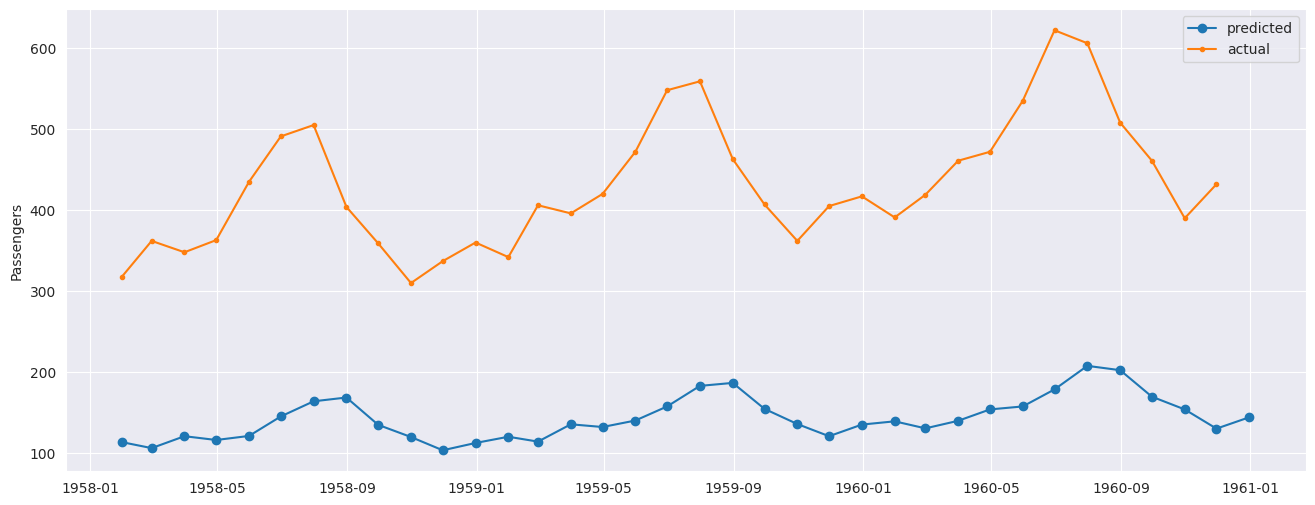

In [10]:
show_result(y_test, predicted)

In [11]:
passengers["month"] = passengers.index.month.values
passengers["year"] = passengers.index.year.values

model = create_model(passengers)
X_train, X_test, y_train, y_test = train_test_split(passengers, passengers.passengers.shift(-1), shuffle=False)
model.fit(X_train, y_train, epochs=100, callbacks=[callback])
predicted = model.predict(X_test)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 588223.1250 - mean_absolute_error: 665.5027 - root_mean_squared_error: 766.6894  
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 582732.6875 - mean_absolute_error: 683.1358 - root_mean_squared_error: 763.3215 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 476558.8125 - mean_absolute_error: 580.3217 - root_mean_squared_error: 690.0342 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 531588.0000 - mean_absolute_error: 638.5638 - root_mean_squared_error: 729.0368 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 558226.4375 - mean_absolute_error: 651.5773 - root_mean_squared_error: 746.9769 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 466031.0000 - mean_absolute_error: 579.7150 - root_mean_squared_error: 682.5852 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 474288.6562 - mean_absolute_error: 584.5543 - root_mean_squared_error: 688.6525 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━

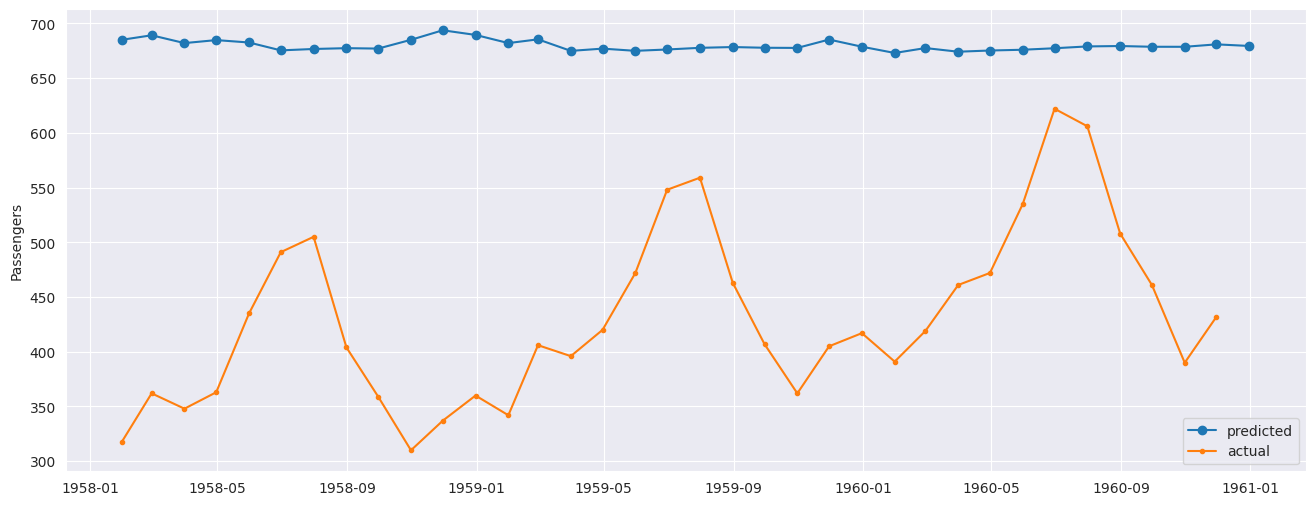

In [12]:
show_result(y_test, predicted)

In [13]:
import tensorflow.keras as keras
import tensorflow as tf

DROPOUT_RATIO = 0.1
HIDDEN_NEURONS = 5

def create_model(passengers):
    scale = tf.constant(passengers.passengers.std())

    continuous_input_layer = keras.layers.Input(shape=(1,))
    categorical_input_layer = keras.layers.Input(shape=(1,))
    embedded = keras.layers.Embedding(12, 5)(categorical_input_layer)
    embedded_flattened = keras.layers.Flatten()(embedded)

    year_input = keras.layers.Input(shape=(1,))
    year_layer = keras.layers.Dense(1)(year_input)

    hidden_output = keras.layers.Concatenate(-1)([
        embedded_flattened, year_layer, continuous_input_layer
    ])
    output_layer = keras.layers.Dense(1)(hidden_output)
    output = output_layer * scale + continuous_input_layer

    model = keras.models.Model(
        inputs=[continuous_input_layer, categorical_input_layer, year_input],
        outputs=output
    )

    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(),
        metrics=[
            keras.metrics.RootMeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
        ]
    )
    return model


In [ ]:
passengers = pd.Series(values, index=idx, name="passengers").to_frame()
passengers["year"] = passengers.index.year.values - passengers.index.year.values.min()
passengers["month"] = passengers.index.month.values - 1

X_train, X_test, y_train, y_test = train_test_split(passengers, passengers.passengers.shift(-1), shuffle=False)
model = create_model(X_train)
model.fit(
  (X_train["passengers"], X_train["year"], X_train["month"]),
  y_train, epochs=1000,
  callbacks=[callback]
)
predicted = model.predict((X_test["passengers"], X_test["year"], X_test["month"]))

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 159034112.0000 - mean_absolute_error: 11841.9170 - root_mean_squared_error: 12602.9307  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 150005808.0000 - mean_absolute_error: 11498.9932 - root_mean_squared_error: 12247.5898 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 140499280.0000 - mean_absolute_error: 11159.5049 - root_mean_squared_error: 11850.4434 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 148661408.0000 - mean_absolute_error: 11443.6836 - root_mean_squared_error: 12191.0469 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 154441008.0000 - mean_absolute_error: 11665.4346 - root_mean_squared_error: 12413.4023 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 152071168.0000 - mean_absolute_error: 11582.3984 - root_mean_squared_error: 12318.6318 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 141217456.0000 - mean_absolute_error: 11126.3506 - root_mean_squa

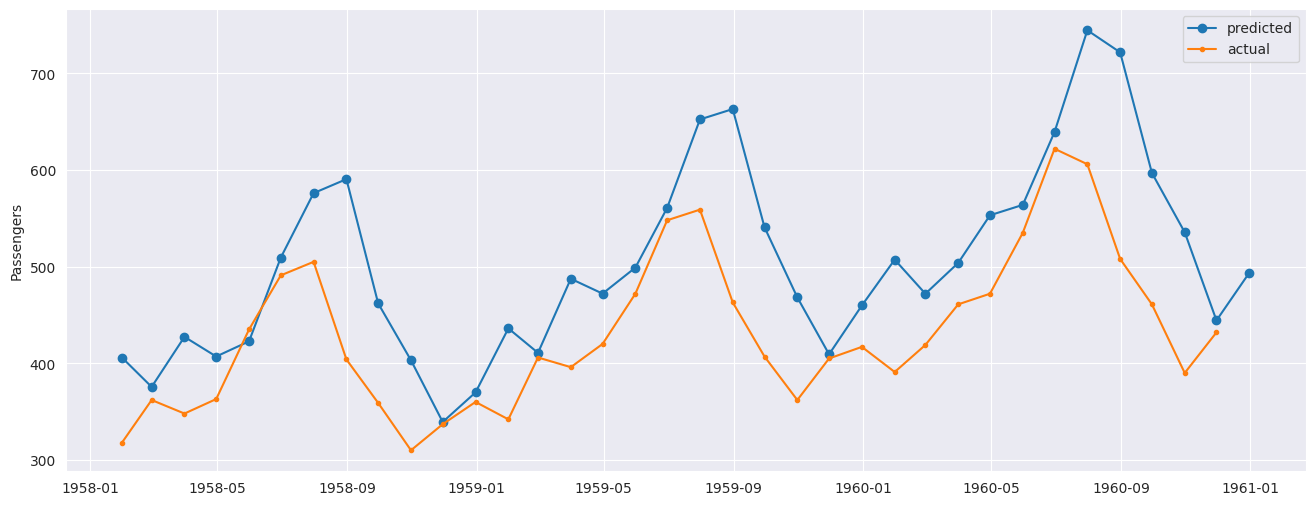

In [25]:
show_result(y_test, predicted)